# This section analyses individual exogenous datapoints via PCA individually



In [41]:
import pandas as pd
# Imports
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.decomposition import KernelPCA



from sklearn.model_selection import KFold
from scikeras.wrappers import KerasRegressor
import matplotlib.pyplot as plt

from imblearn.over_sampling import SMOTE



## Function declarations

In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

def process_data(file_path, row_thresh_multiplier=0.5):
    # Load the data
    tempData = pd.read_csv(file_path, parse_dates=['Time'], index_col='Time')
    print("Array size:", tempData.shape)
    
    # Drop rows where more than half the columns have missing values
    row_thresh = len(tempData.columns) * row_thresh_multiplier
    tempData = tempData.dropna(axis=0, thresh=row_thresh)
    print("Array size:", tempData.shape)
    
    # Drop any columns with missing values
    tempData = tempData.dropna(axis=1, how='any')
    print("Array size:", tempData.shape)
    
    # Group data by 'Time', calculate the mean, and reset the index
    daily_Data = tempData.groupby(tempData.index).mean().reset_index()
    daily_Data['Time_ordinal'] = pd.to_datetime(daily_Data['Time']).apply(lambda x: x.toordinal())
    
    return daily_Data

def perform_pca(data, columns_to_exclude):
    # Standardize columns excluding specified columns
    columns_to_standardize = [col for col in data.columns[1:] if col not in columns_to_exclude]
    x = StandardScaler().fit_transform(data[columns_to_standardize].values)
    
    # Perform PCA
    pca = PCA(n_components=2)
    principalComponents = pca.fit_transform(x)
    principalDf = pd.DataFrame(data=principalComponents, columns=['principal component 1', 'principal component 2'])
    
    # Display explained variance
    print("Explained Variance Ratio:", pca.explained_variance_ratio_)
    
    return principalDf, pca.explained_variance_ratio_

def plot_pca(principalDf, explained_variance_ratios, year_values, title, ax):
    pc1_variance_ratio = explained_variance_ratios[0] * 100
    pc2_variance_ratio = explained_variance_ratios[1] * 100
    
    # Plot the results
    scatter = ax.scatter(principalDf['principal component 1'], principalDf['principal component 2'],
                         c=year_values, cmap='viridis', alpha=0.7)
    ax.set_title(title)
    ax.set_xlabel(f'Principal Component 1 ({pc1_variance_ratio:.2f}%)')
    ax.set_ylabel(f'Principal Component 2 ({pc2_variance_ratio:.2f}%)')
    return scatter




In [43]:
TIMESCALE = "Monthly"
# File path of the data
Plotting_file_paths = [
    {'file_path': f'../../[A1] - GET_EXOG_VARS/{TIMESCALE}MeanTempData.csv', 'title': 'Daily Mean Temperature', 'row_thresh_multiplier': 0.5},
    {'file_path': f'../../[A1] - GET_EXOG_VARS/{TIMESCALE}MeanDryAir.csv', 'title': 'Daily Mean Dry Air', 'row_thresh_multiplier': 0.5},
    {'file_path': f'../../[A1] - GET_EXOG_VARS/{TIMESCALE}MeanStorageVolume.csv', 'title': 'Daily Mean Storage Volume', 'row_thresh_multiplier': 0.56},
    {'file_path': f'../../[A1] - GET_EXOG_VARS/{TIMESCALE}MeanEC.csv', 'title': 'Daily Electrical Conductivity', 'row_thresh_multiplier': 0.5},
    {'file_path': f'../../[A1] - GET_EXOG_VARS/{TIMESCALE}MeanRainfall.csv', 'title': 'Daily Rainfall', 'row_thresh_multiplier': 0.5},
    {'file_path': f'../../[A1] - GET_EXOG_VARS/{TIMESCALE}MeanWaterCourseDischarge.csv', 'title': 'Daily Mean Water Course Discharge', 'row_thresh_multiplier': 0.5},
    # Add more datasets as needed
]


Array size: (169, 400)
Array size: (166, 400)
Array size: (166, 14)
Explained Variance Ratio: [0.91500314 0.05664095]
Array size: (230, 11)
Array size: (37, 11)
Array size: (37, 3)
Explained Variance Ratio: [0.98602368 0.00924693]
Array size: (331, 135)
Array size: (166, 135)
Array size: (166, 16)
Explained Variance Ratio: [0.44543304 0.14541226]
Array size: (337, 310)
Array size: (167, 310)
Array size: (167, 9)
Explained Variance Ratio: [0.36308942 0.1557539 ]
Array size: (169, 720)
Array size: (169, 720)
Array size: (169, 94)
Explained Variance Ratio: [0.47499608 0.13848253]
Array size: (169, 1351)
Array size: (169, 1351)
Array size: (169, 313)
Explained Variance Ratio: [0.45001863 0.10514082]


/var/folders/d9/x_bnq71n58lbk4_znq_twz6h0000gn/T/ipykernel_64924/496719942.py:41: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0, 0.08, 1, 1])


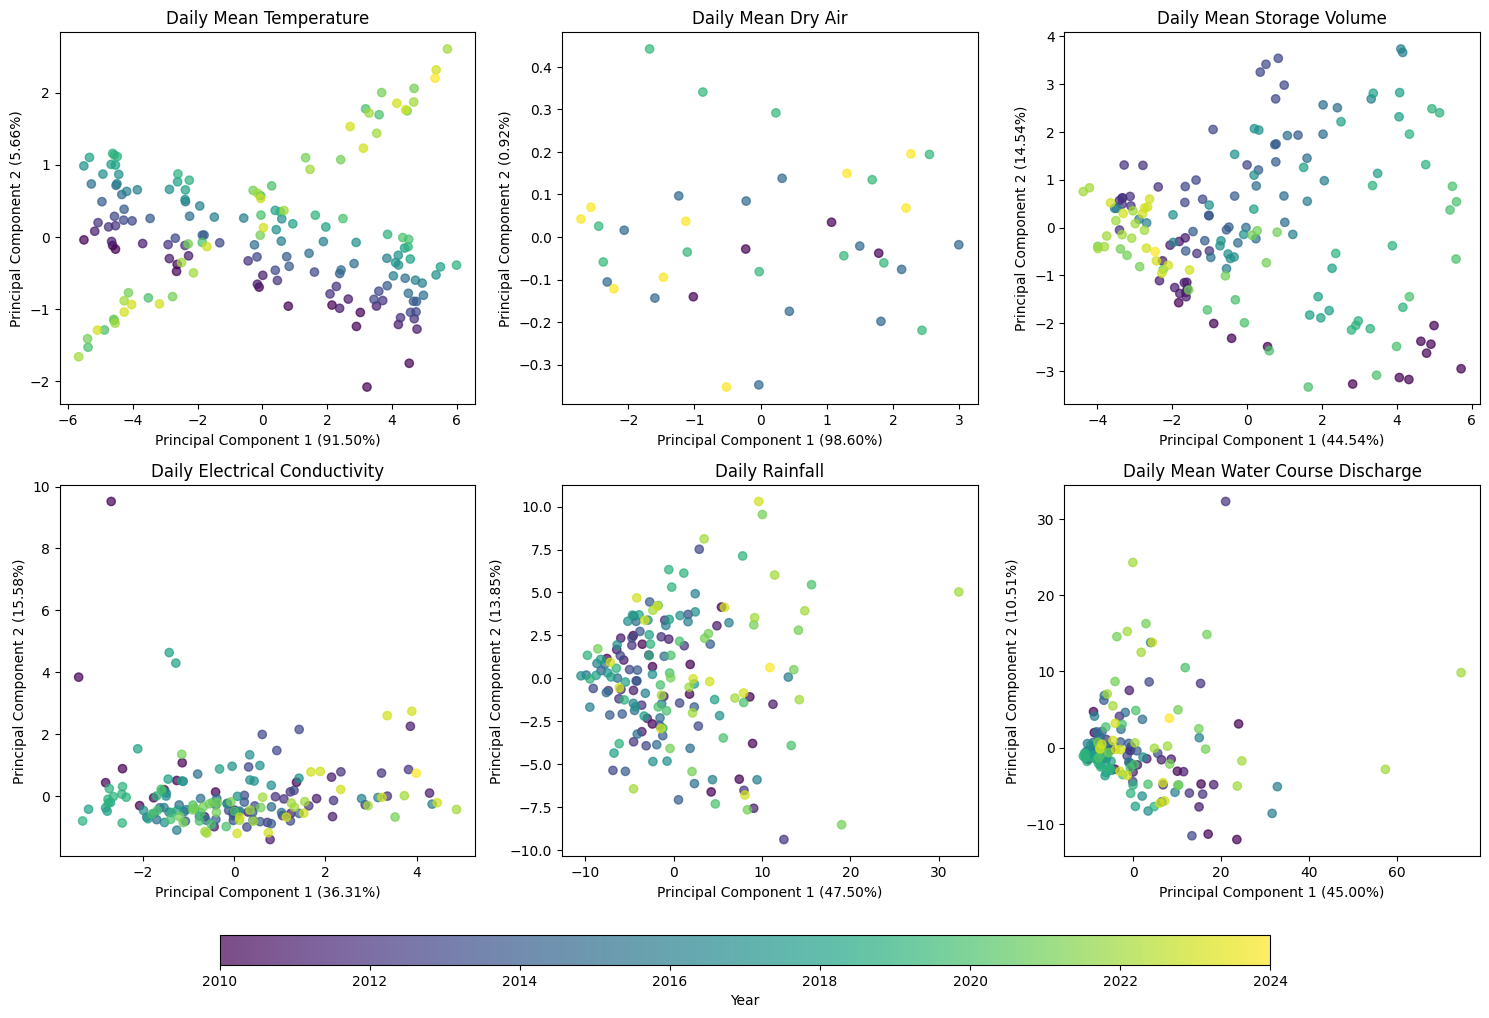

FileNotFoundError: [Errno 2] No such file or directory: '../imgs/PCA_EXOG_individual.png'

In [44]:


# Specify the columns to exclude from standardization
columns_to_exclude = ['Status', 'Application Creation Date', 'Approved / Refused Date', 'Recorded / Rejected Date',
                      'Water Share ID', 'Water System Source', 'Reliability', 'Trading Zone Source',
                      'Seller Water Authority', 'Seller Trading Zone Use', 'Buyer Water Authority',
                      'Buyer Trading Zone Use', 'Create_date', 'Create_date_ordinal', 'Cluster', 'Time',
                      'Time_ordinal', 'Price Per ML ($)', 'Volume Traded (ML)']

# Create a figure and axes for subplots
num_plots = len(Plotting_file_paths)
num_cols = 3
num_rows = (num_plots + num_cols - 1) // num_cols
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5*num_rows))
axes = axes.flatten()

for i, dataset in enumerate(Plotting_file_paths):
    file_path = dataset['file_path']
    title = dataset['title']
    row_thresh_multiplier = dataset['row_thresh_multiplier']
    
    # Process the data
    data = process_data(file_path, row_thresh_multiplier)
    
    # Extract year values from the 'Time' column
    year_values = pd.to_datetime(data['Time']).dt.year
    
    # Perform PCA
    principal_df, explained_variance_ratios = perform_pca(data, columns_to_exclude)
    
    # Plot the PCA results
    scatter = plot_pca(principal_df, explained_variance_ratios, year_values, title, axes[i])


# Remove unused subplots
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

cbar_ax = fig.add_axes([0.15, 0.03, 0.7, 0.03])
cbar = fig.colorbar(scatter, cax=cbar_ax, orientation='horizontal', label='Year')

# Adjust the spacing between subplots
fig.tight_layout(rect=[0, 0.08, 1, 1])

# Show the plot
plt.show()

# Save the figure to a file
fig.savefig('../imgs/PCA_EXOG_individual.png', bbox_inches='tight', dpi=300)
